# The Battle of Neighborhoods

## 1. Introduction

Where to open a Chinese Restaurants

In [1]:
import numpy as np
import pandas as pd
import requests

!pip install geocoder
import geocoder

from bs4 import BeautifulSoup

     |████████████████████████████████| 102kB 8.2MB/s ta 0:00:011


In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')

postal_codes_dict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_data = pd.DataFrame(columns=columns)
toronto_data

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    toronto_data = toronto_data.append({"PostalCode": postal_code, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)

# print number of rows of dataframe
toronto_data.shape[0]

103

In [3]:
toronto_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government


In [4]:
def get_coord(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

postal_codes = toronto_data['PostalCode'] 
coords = [get_coord(postal_code) for postal_code in postal_codes.tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
toronto_data['Latitude'] = df_coords['Latitude']
toronto_data['Longitude'] = df_coords['Longitude']
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752420,-79.329242
1,M4A,North York,Victoria Village,43.730600,-79.313265
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650295,-79.359166
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723270,-79.451286
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.661150,-79.391715


### 1. Explore and cluster the neighborhoods in Toronto

In [6]:
from geopy.geocoders import Nominatim
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ------------------------------------------------------------
                       

In [7]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [8]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'P2CNRZHGGN5IL2N5T3PZ204A5HX5321BQC54BX2MKRW2S5CO' # your Foursquare ID
CLIENT_SECRET = 'XDEK3C3AZJC3GIBIT35EO0KT1AYRO1IRJ1UMXZXVVJ4FGXVL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: P2CNRZHGGN5IL2N5T3PZ204A5HX5321BQC54BX2MKRW2S5CO
CLIENT_SECRET:XDEK3C3AZJC3GIBIT35EO0KT1AYRO1IRJ1UMXZXVVJ4FGXVL


### Explore Neighborhoods in Toronto

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview Ea

In [12]:
print(toronto_venues.shape)
toronto_venues.head()

(2486, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.752420,-79.329242,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.752420,-79.329242,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.730600,-79.313265,Wigmore Park,43.731023,-79.310771,Park
3,Victoria Village,43.730600,-79.313265,Memories of Africa,43.726602,-79.312427,Grocery Store
4,"Regent Park, Harbourfront",43.650295,-79.359166,The Distillery Historic District,43.650244,-79.359323,Historic Site


In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 265 uniques categories.


## Get the dataframe of Restaurants

In [19]:
# find information of toronto's restaurants and malls
toronto_restaurant = toronto_venues.loc[toronto_venues['Venue Category'].str.contains('Restaurant')]
toronto_mall = toronto_venues.loc[toronto_venues['Venue Category'].str.contains('Mall')]
# toronto_mall

#change 'Venue Category' to 'Restaurant' for all venues whose Category contians 'Restaurant', for further exploration.
toronto_venues_restaurant = toronto_venues.copy()
toronto_venues_restaurant['Venue Category'].loc[toronto_venues_restaurant['Venue Category'].str.contains('Restaurant')] = 'Restaurant'
toronto_venues_restaurant


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.752420,-79.329242,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.752420,-79.329242,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.730600,-79.313265,Wigmore Park,43.731023,-79.310771,Park
3,Victoria Village,43.730600,-79.313265,Memories of Africa,43.726602,-79.312427,Grocery Store
4,"Regent Park, Harbourfront",43.650295,-79.359166,The Distillery Historic District,43.650244,-79.359323,Historic Site
5,"Regent Park, Harbourfront",43.650295,-79.359166,Arvo,43.649963,-79.361442,Coffee Shop
6,"Regent Park, Harbourfront",43.650295,-79.359166,Distillery Sunday Market,43.650075,-79.361832,Farmers Market
7,"Regent Park, Harbourfront",43.650295,-79.359166,Cacao 70,43.650067,-79.360723,Dessert Shop
8,"Regent Park, Harbourfront",43.650295,-79.359166,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
9,"Regent Park, Harbourfront",43.650295,-79.359166,Balzac's Coffee,43.649797,-79.359142,Coffee Shop


In [56]:
toronto_mall

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
44,"Lawrence Manor, Lawrence Heights",43.723270,-79.451286,Yorkdale Shopping Centre,43.725482,-79.452736,Shopping Mall
153,Islington Avenue,43.662299,-79.528195,Thorncrest Plaza,43.662620,-79.532146,Shopping Mall
204,"Garden District, Ryerson",43.657363,-79.378180,CF Toronto Eaton Centre,43.654540,-79.380677,Shopping Mall
426,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.648573,-79.578250,Renforth Plaza,43.651194,-79.579612,Shopping Mall
488,Berczy Park,43.645160,-79.373675,Brookfield Place,43.646791,-79.378769,Shopping Mall
527,Leaside,43.709495,-79.363989,Leaside Village,43.705682,-79.360777,Shopping Mall
579,Central Bay Street,43.656091,-79.384930,CF Toronto Eaton Centre,43.654540,-79.380677,Shopping Mall
794,"Fairview, Henry Farm, Oriole",43.780970,-79.347813,CF Fairview Mall,43.777994,-79.343665,Shopping Mall
979,"Toronto Dominion Centre, Design Exchange",43.647100,-79.381531,Brookfield Place,43.646791,-79.378769,Shopping Mall
1204,"Commerce Court, Victoria Hotel",43.648395,-79.378865,Brookfield Place,43.646791,-79.378769,Shopping Mall


In [ ]:
# #test
# toronto_venues2 = toronto_venues
# # toronto_venues2.where(toronto_venues2['Venue Category'].str.contains('Restaurant') , 'Restaurant', axis = 1)
# toronto_venues2['Venue Category'].loc[toronto_venues2['Venue Category'].str.contains('Restaurant')] = 'Restaurant'
# toronto_venues2['Venue Category'].loc[toronto_venues2['Venue Category'].str.contains('Restaurant')]
# toronto_venues2

count the number of restaurants for every Neighborhood. Restaurants could spread around shopping mall, so we also get the dataframe of shopping malls and count the number

In [20]:
t_restaurant_count = toronto_restaurant.groupby(['Neighborhood']).count().reset_index()
t_mall_count = toronto_mall.groupby(['Neighborhood']).count()
t_restaurant_count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,6,6,6,6,6,6
1,"Bedford Park, Lawrence Manor East",9,9,9,9,9,9
2,Berczy Park,14,14,14,14,14,14
3,"Brockton, Parkdale Village, Exhibition Place",15,15,15,15,15,15
4,"CN Tower, King and Spadina, Railway Lands, Har...",21,21,21,21,21,21
5,Caledonia-Fairbanks,1,1,1,1,1,1
6,Central Bay Street,22,22,22,22,22,22
7,Christie,1,1,1,1,1,1
8,Church and Wellesley,24,24,24,24,24,24
9,"Clairville, Humberwood, Woodbine Downs, West H...",2,2,2,2,2,2


In [21]:
toronto_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,"Regent Park, Harbourfront",43.650295,-79.359166,Cluny Bistro & Boulangerie,43.650565,-79.357843,Restaurant
16,"Regent Park, Harbourfront",43.650295,-79.359166,El Catrin,43.650601,-79.358920,Restaurant
20,"Regent Park, Harbourfront",43.650295,-79.359166,Izumi,43.649970,-79.360153,Restaurant
56,"Lawrence Manor, Lawrence Heights",43.723270,-79.451286,RH Courtyard Café,43.724874,-79.455536,Restaurant
59,"Lawrence Manor, Lawrence Heights",43.723270,-79.451286,JOEY,43.724131,-79.454042,Restaurant


## plot bar chart of number of restaurants

In [22]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

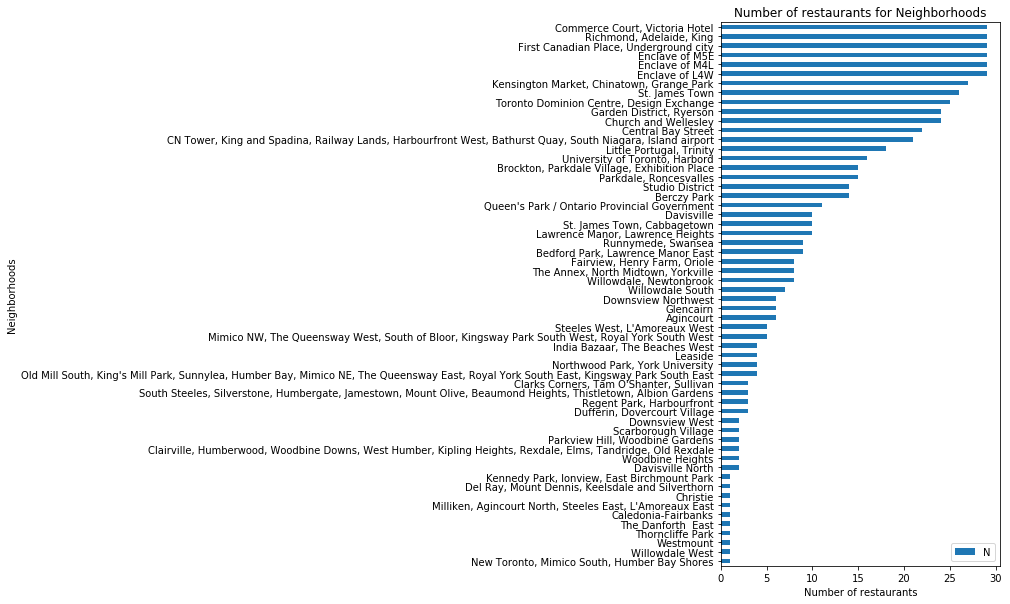

In [55]:
# t_restaurant_count.sort_values(by=['Venue'],ascending=False).plot.bar(x='Neighborhood', y='Venue', figsize=(10,6) )
ax = t_restaurant_count_sort = t_restaurant_count.sort_values(by=['Venue']).plot.barh(x='Neighborhood', y='Venue', figsize=(5,10), legend=False)
# neibor = t_restaurant_count_sort['Neiborhood']
# n_restaurants = t_restaurant_count_sort['Venue']
# plt.barh(t_restaurant_count_sort['Venue'], t_restaurant_count_sort['Neighborhood'])

plt.title('Number of restaurants for Neighborhoods')
plt.xlabel('Number of restaurants')
plt.ylabel('Neighborhoods')
plt.legend('Number of restaurants')

## draw the map to show the spread of restaurants and shopping malls

In [24]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue_name, venue_category in zip(toronto_restaurant['Venue Latitude'], toronto_restaurant['Venue Longitude'], toronto_restaurant['Venue'], toronto_restaurant['Venue Category']):
    label = '{}, {}'.format(venue_name, venue_category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  

for lat, lng, venue_name, venue_category in zip(toronto_mall['Venue Latitude'], toronto_mall['Venue Longitude'], toronto_mall['Venue'], toronto_mall['Venue Category']):
    label = '{}, {}'.format(venue_name, venue_category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#99FFFF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  

map_Toronto

## Onehot

In [25]:
toronto_onehot = pd.get_dummies(toronto_venues_restaurant[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues_restaurant['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_res_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_res_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,Trail,Train Station,Tram Station,Transportation Service,Video Game Store,Video Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2,Bayview Village,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
3,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
4,Berczy Park,0.000000,0.0,0.000000,0.00,0.000000,0.016129,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
5,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
6,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.00,0.000000,0.013889,0.000000,0.013889,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
7,"CN Tower, King and Spadina, Railway Lands, Har...",0.014925,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
8,Caledonia-Fairbanks,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.111111
9,Cedarbrae,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [26]:
toronto_res = toronto_res_grouped[["Neighborhood","Restaurant"]]
toronto_res.head()

,Neighborhood,Restaurant
0,Agincourt,0.352941
1,"Alderwood, Long Branch",0.000000
2,Bayview Village,0.000000
3,"Bedford Park, Lawrence Manor East",0.391304
4,Berczy Park,0.225806


In [27]:
toronto_res_clustering = toronto_res.drop('Neighborhood', 1)
toronto_res_clustering.head()

,Restaurant
0,0.352941
1,0.000000
2,0.000000
3,0.391304
4,0.225806


Find the best K for k means, The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

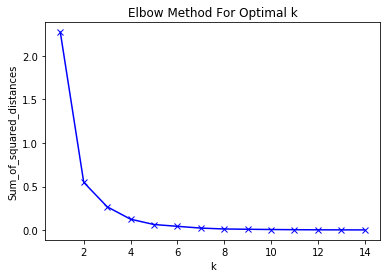

In [28]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_res_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

the best K = 6

In [29]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_res_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 0, 0, 3, 3, 0, 2, 3, 2, 0, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 3, 2, 2, 3, 3, 3, 0, 2, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 3, 0, 2, 0, 2, 3, 0, 1, 3, 0, 2, 0, 0, 3, 1, 3, 2, 0,
       3, 0, 3, 0, 0, 2, 0, 1, 2, 3, 3, 3, 3, 0, 3, 0, 3, 0, 0, 2, 3, 3,
       0, 2, 0, 0, 3, 2, 3, 0, 2, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [58]:
toronto_merged = toronto_res.copy()
# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_
# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# toronton_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Neighborhood,Restaurant,Cluster Labels
0,Agincourt,0.352941,3
1,"Alderwood, Long Branch",0.000000,0
2,Bayview Village,0.000000,0
3,"Bedford Park, Lawrence Manor East",0.391304,3
4,Berczy Park,0.225806,3


In [59]:
toronto_merged = toronto_merged.join(toronto_data.set_index("Neighborhood"), on="Neighborhood")
toronto_merged

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
0,Agincourt,0.352941,3,M1S,Scarborough,43.793940,-79.267976
1,"Alderwood, Long Branch",0.000000,0,M8W,Etobicoke,43.601131,-79.538785
2,Bayview Village,0.000000,0,M2K,North York,43.781015,-79.380529
3,"Bedford Park, Lawrence Manor East",0.391304,3,M5M,North York,43.735460,-79.419148
4,Berczy Park,0.225806,3,M5E,Downtown Toronto,43.645160,-79.373675
5,"Birch Cliff, Cliffside West",0.000000,0,M1N,Scarborough,43.696770,-79.259967
6,"Brockton, Parkdale Village, Exhibition Place",0.208333,2,M6K,West Toronto,43.639410,-79.424362
7,"CN Tower, King and Spadina, Railway Lands, Har...",0.313433,3,M5V,Downtown Toronto,43.640815,-79.399538
8,Caledonia-Fairbanks,0.111111,2,M6E,York,43.688640,-79.451018
9,Cedarbrae,0.000000,0,M1H,Scarborough,43.769688,-79.239440


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
for lat, lng, venue_name, venue_category in zip(toronto_mall['Venue Latitude'], toronto_mall['Venue Longitude'], toronto_mall['Venue'], toronto_mall['Venue Category']):
    label = '{}, {}'.format(venue_name, venue_category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#99FFFF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)         

map_clusters

Let's show the results of clusters

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0, 1, 2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Restaurant,Cluster Labels,Latitude,Longitude
1,"Alderwood, Long Branch",0.000,0,43.601131,-79.538785
2,Bayview Village,0.000,0,43.781015,-79.380529
5,"Birch Cliff, Cliffside West",0.000,0,43.696770,-79.259967
9,Cedarbrae,0.000,0,43.769688,-79.239440
15,"Cliffside, Cliffcrest, Scarborough Village West",0.000,0,43.724235,-79.227925
20,Don Mills North,0.000,0,43.749055,-79.362227
21,Don Mills South,0.000,0,43.721425,-79.343454
22,"Dorset Park, Wexford Heights, Scarborough Town...",0.000,0,43.759975,-79.268974
23,Downsview Central,0.000,0,43.733690,-79.496740
24,Downsview East,0.000,0,43.738685,-79.467320


In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Restaurant,Cluster Labels,Latitude,Longitude
36,Glencairn,0.500000,1,43.707990,-79.448367
55,"Milliken, Agincourt North, Steeles East, L'Amo...",0.500000,1,43.817685,-79.280187
62,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.666667,1,43.632835,-79.489550
73,Scarborough Village,0.500000,1,43.743125,-79.231750


In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Restaurant,Cluster Labels,Latitude,Longitude
6,"Brockton, Parkdale Village, Exhibition Place",0.208333,2,43.639410,-79.424362
8,Caledonia-Fairbanks,0.111111,2,43.688640,-79.451018
11,Christie,0.090909,2,43.668781,-79.420710
26,Downsview West,0.166667,2,43.720140,-79.516980
27,"Dufferin, Dovercourt Village",0.142857,2,43.665087,-79.438705
32,"Fairview, Henry Farm, Oriole",0.153846,2,43.780970,-79.347813
45,"India Bazaar, The Beaches West",0.200000,2,43.667965,-79.314667
47,"Kennedy Park, Ionview, East Birchmount Park",0.200000,2,43.726276,-79.263625
50,"Lawrence Manor, Lawrence Heights",0.181818,2,43.723270,-79.451286
52,Leaside,0.111111,2,43.709495,-79.363989


In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Restaurant,Cluster Labels,Latitude,Longitude
0,Agincourt,0.352941,3,43.793940,-79.267976
3,"Bedford Park, Lawrence Manor East",0.391304,3,43.735460,-79.419148
4,Berczy Park,0.225806,3,43.645160,-79.373675
7,"CN Tower, King and Spadina, Railway Lands, Har...",0.313433,3,43.640815,-79.399538
10,Central Bay Street,0.229167,3,43.656091,-79.384930
12,Church and Wellesley,0.279070,3,43.666585,-79.381302
13,"Clairville, Humberwood, Woodbine Downs, West H...",0.250000,3,43.711740,-79.579181
14,"Clarks Corners, Tam O'Shanter, Sullivan",0.250000,3,43.784725,-79.299066
16,"Commerce Court, Victoria Hotel",0.290000,3,43.648395,-79.378865
17,Davisville,0.333333,3,43.703395,-79.385964


# 